In [1]:
# System libraries
from time import time
import random

# Custom libraries
# import dl_utils as utils
import datasets

# Helper libraries
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib inline

In [2]:
tfw = 'v1'
if tfw == 'v1':
    print("TF v1 behaviour enabled")
    import tensorflow.compat.v1 as tf
    # Enable tf v1 behavior as in v2 a lot have changed    
    tf.disable_v2_behavior() 
else:
    print("TF v2 behaviour enabled")
    import tensorflow as tf
    
print("Tensorflow version",tf.__version__)

TF v1 behaviour enabled
Instructions for updating:
non-resource variables are not supported in the long term
Tensorflow version 1.14.1


In [3]:
X, Y = datasets.data_spiral(10000,0)

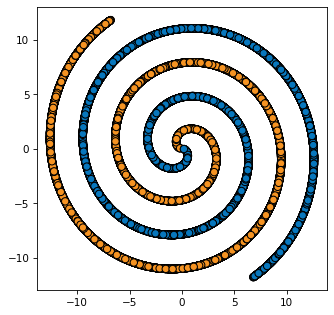

In [4]:
plt.figure(figsize=(5, 5), dpi=75)
colormap = colors.ListedColormap(["#f59322", "#e8eaeb", "#0877bd"])
x_min, x_max = -6, 6  # grid x bounds
y_min, y_max = -6, 6  # grid y bounds

plt.scatter(X[:,0],X[:,1],edgecolors='k', s=50, c=Y, cmap=colormap)
plt.savefig('plots/spiral_dataset.png')


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.33)

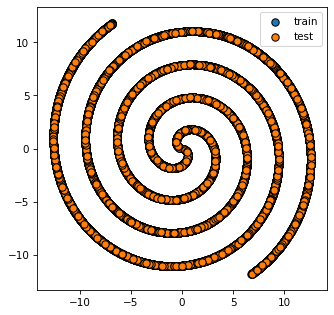

In [6]:
plt.figure(figsize=(5, 5), dpi=75)
colormap = colors.ListedColormap(["#f59322", "#e8eaeb", "#0877bd"])
x_min, x_max = -6, 6  # grid x bounds
y_min, y_max = -6, 6  # grid y bounds

plt.scatter(X_train[:,0],X_train[:,1], edgecolors='k', s=50, cmap=colormap,label='train')
plt.scatter(X_test[:,0],X_test[:,1], edgecolors='k', s=50, cmap=colormap, label='test')
plt.legend()

In [4]:
## Build NN - Hyperparameters ##
epochs = 100
lr = 0.001

In [2]:
def create_model():
    model = tf.keras.Sequential()
    
    # Input Layers
    model.add(tf.keras.layers.Dense(8,input_dim=2,activation='relu'))
    model.add(tf.keras.layers.Dense(8,activation='relu'))
    model.add(tf.keras.layers.Dense(8,activation='relu'))
    model.add(tf.keras.layers.Dense(8,activation='relu'))
    
    # Output Layer
    model.add(tf.keras.layers.Dense(2,activation='softmax'))
    
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(lr),
                 metrics=['accuracy'])
    
    return model

In [5]:
model = create_model()

In [10]:
model_train = time()
results = model.fit(X_train,y_train,
                    batch_size=64,
                    epochs=epochs,
                    validation_data=(X_test,y_test),
                    verbose=0
                   )
keras_train = time() - model_train
print('Model training time %.1f sec' % keras_train)

Model training time 55.6 sec


In [11]:
print("Evaluating on train set...")
(loss, accuracy) = model.evaluate(X_train, y_train.T, verbose=0)
print("loss={:.4f}, accuracy: {:.2f}%".format(loss,accuracy * 100))

print("Evaluating on test set...")
(loss, accuracy) = model.evaluate(X_test, y_test.T, verbose=0)
print("loss={:.4f}, accuracy: {:.2f}%".format(loss,accuracy * 100))

Evaluating on train set...
loss=0.0000, accuracy: 100.00%
Evaluating on test set...
loss=0.0000, accuracy: 100.00%


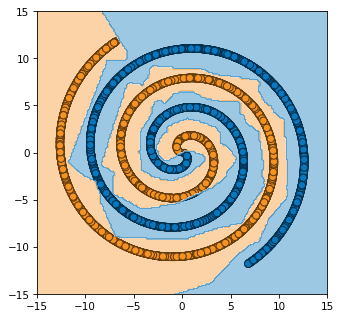

In [12]:
plt.figure(figsize=(5, 5), dpi=75)
colormap = colors.ListedColormap(["#f59322", "#e8eaeb", "#0877bd"])

# Create a grid of points to predict
x, _, xx, yy = datasets.grid_points()

# Grid predictions
z_preds = model.predict(x)

# Test predictions
predictions = model.predict(X_test)

z_preds = np.argmax(z_preds,axis=1)
plt.scatter(X_test[:,0],X_test[:,1], c=predictions[:,1], edgecolors='k', s=50, cmap=colormap)
plt.contourf(xx,yy,z_preds.reshape(xx.shape), cmap=colormap, alpha=0.4)

## Implementation with TF 1.14

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

In [4]:
logdir = './logs'

In [21]:
class NeuralNet:
    
    def __init__(self, n_X = 1000, noise_X = 0, session_type='cpu'):
        self.lr = 0.001
        self.verbose = 0
        self.batch_size = 64
        self.n_X = n_X
        self.noise_X = noise_X
        tf.reset_default_graph()
        if session_type == 'cpu':
            self.sess = tf.Session()
        else:
            self.sess = tf
        
    def get_data(self):
   
        # Fetch dataset
        X,Y = datasets.data_spiral(self.n_X,self.noise_X)
        
        # Fetch test set - grid points
        X_test, y_test, _, _ = datasets.grid_points()
        
        # Split dataset for train and validation
        X_train, self.X_valid, y_train, y_valid = train_test_split(X,Y,test_size=0.33)
        self.valid_len = len(self.X_valid)
        print("Train size", X_train.shape)
        print("Valid size", self.X_valid.shape)
        print("Test size", X_test.shape)        
        
        try:
            assert(X_train.shape[1] == X_test.shape[1])
        except AssertionError as e:            
            raise( AssertionError( "Dataset input size is not equal. %s"%e ) )            

        with tf.name_scope('data'):

            # Define placeholders for test set, since eval() is used
            x_test_pl = tf.placeholder(dtype = X_test.dtype,shape = X_test.shape)
            y_test_pl = tf.placeholder(dtype = y_test.dtype,shape = y_test.shape)

            # Create tensorflow compatible dataset with tf.data api (no placeholders)
            train_data = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(self.batch_size,drop_remainder=True)
            valid_data = tf.data.Dataset.from_tensor_slices((self.X_valid,y_valid)).batch(self.batch_size,drop_remainder=False)
            test_data = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(self.batch_size,drop_remainder=False)

            ## Define Iterators
            self.iterator = tf.data.Iterator.from_structure(train_data.output_types, 
                                                          train_data.output_shapes)

            self.train_init_op = self.iterator.make_initializer(train_data)
            self.valid_init_op = self.iterator.make_initializer(valid_data)
            self.test_init_op = self.iterator.make_initializer(test_data)       

            # Create test feed dict for inference
            self.test_feed_dict = {x_test_pl: X_test, 
                                   y_test_pl: y_test}

            # Take the next sample-label for the infered set into the computational Graph
            self.sample, self.labels = self.iterator.get_next()
            #self.sample = tf.reshape(self.sample,[-1,1])        
            self.labels = tf.one_hot(self.labels,depth=2,name='y1h')                
            #self.labels = tf.reshape(self.labels,[-1,1])
            self.labels = tf.cast(self.labels,tf.float32)
            self.sample = tf.cast(self.sample,tf.float32)      
       

    def model(self):
        '''
        Build model architecture using functional API
        '''
        with tf.name_scope('architecture'):
            l1 = tf.layers.Dense(8,
                            activation=tf.nn.relu,
                            kernel_initializer=tf.keras.initializers.glorot_normal(),
                            name="hidden_1")(self.sample)
            l2 = tf.layers.Dense(8,
                            activation=tf.nn.relu,
                            name="hidden_2")(l1)
            l3 = tf.layers.Dense(8,
                           activation=tf.nn.relu,
                           name="hidden_2")(l2)
            l4 = tf.layers.Dense(8,
                           activation=tf.nn.relu,
                           name="hidden_2")(l3)

            self.logits = tf.layers.Dense(2,
                                    activation=tf.nn.softmax,
                                    name="output")(l4)
            #self.logits = tf.transpose(self.logits)

    def loss(self):
        '''
        Compute loss of the model
        '''
        with tf.name_scope('loss'):

            #entropy = tf.keras.losses.binary_crossentropy(self.labels,self.logits,from_logits=True)
            #entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.labels, logits=self.logits)
            entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits)
            self.loss = tf.reduce_mean(entropy,axis=0, name='loss')
            tf.summary.scalar('loss',self.loss)
        print("Labels shape:", self.labels.shape)
        print("Logits shape:", self.logits.shape)             
        
    
    def optimize(self):
        '''
        Define Optimizer method to minimize loss
        '''
        with tf.name_scope('optimize'):
            self.opt = tf.train.AdamOptimizer(self.lr).minimize(self.loss)                                                        
            #self.opt = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss)
   
    def evaluate(self):
        '''
        Compute predictions and accuracy in a batch
        '''
        with tf.name_scope('predict'):
            #self.preds = tf.nn.sigmoid(self.logits)
            #self.preds = tf.nn.softmax(self.logits)            
            #preds = tf.cast(preds > 0.5, tf.int64)
            
            self.predictions = tf.nn.sigmoid(self.logits)
            self.correct_preds = tf.equal(tf.argmax(self.predictions, -1), tf.argmax(self.labels, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_preds, tf.float32))
            tf.summary.scalar('accuracy',self.accuracy)

    def build(self):
        '''
        Build the computation graph
        '''
        self.get_data()
        self.model()
        self.loss()
        self.optimize()
        self.evaluate() 

    def train_predict(self, epochs):
        '''
        Train and evaluate model
        :param epochs: number of epochs
        :return: predictions
        '''
        merged = tf.summary.merge_all()        
        writer = tf.summary.FileWriter(logdir + '/graphs', tf.get_default_graph())
        train_writer = tf.summary.FileWriter(logdir + '/train', self.sess.graph)
        test_writer = tf.summary.FileWriter(logdir + '/test')            
        self.sess.run(tf.global_variables_initializer())
        print("Start training process...")
        for epoch in range(epochs):
            self.sess.run(self.train_init_op)
            total_loss = 0
            n_batches = 0
            sum_train_acc = 0
            try:
                while True:                      
                    summary, _ , loss, train_acc = self.sess.run([merged,self.opt,self.loss,self.accuracy])
                    total_loss += loss
                    sum_train_acc += train_acc
                    n_batches += self.batch_size
                    train_writer.add_summary(summary, epoch)
                    
            except tf.errors.OutOfRangeError:                    
                pass            

            if epoch % 20 == 0:
                print("Epoch: {}, Average loss: {:.4f}, Train Accuracy: {:.2f}%".format(
                        epoch,
                        total_loss/n_batches,
                        #(sum_train_acc/n_batches)*100))
                        train_acc))
        train_writer.close()

        ## Evaluation ##
        print("\nEvaluating...")
        self.sess.run(self.valid_init_op)
        sum_acc = 0
        sum_loss = 0
        sum_preds = []
        try:
            while True:                    
                summary, batch_val_loss, batch_val_acc, preds = self.sess.run([merged,
                                                                      self.loss,
                                                                      self.accuracy,
                                                                      self.predictions])
                sum_loss += batch_val_loss
                sum_acc += batch_val_acc
                sum_preds.append(preds)          
                test_writer.add_summary(summary, epoch)
        except tf.errors.OutOfRangeError:                    
            pass
        
        test_writer.close()
        writer.close()
        print("Average Validation loss: {:.4f}, Validation Accuracy: {:.2f}%".format(
                sum_loss/self.valid_len,
                #(sum_acc/self.valid_len)*100))
                batch_val_acc))
        
        return np.concatenate(sum_preds)

    def test_plot(self,predictions):
        '''
        Infer test set to the trained model and plot predictions
        :param predictions: array of predicted labels
        :return: None
        '''
        ## Test Set ##
        self.sess.run(self.test_init_op)
        z_preds = []
        try:
            while True:                 
                z = self.predictions.eval(session = self.sess,feed_dict=self.test_feed_dict)                    
                z_preds.append(z) 
        except tf.errors.OutOfRangeError:                    
            pass

        plt.figure(figsize=(5, 5), dpi=75)
        colormap = colors.ListedColormap(["#f59322", "#e8eaeb", "#0877bd"])
        _,_,xx,yy = datasets.grid_points()

        z_preds = np.concatenate(z_preds)
        z_preds = np.argmax(z_preds,axis=1)

        plt.scatter(self.X_valid[:,0],self.X_valid[:,1], c=predictions[:,1], edgecolors='k', s=50, cmap=colormap)            
        plt.contourf(xx,yy,z_preds.reshape(xx.shape), cmap=colormap, alpha=0.4) 

In [22]:
nn = NeuralNet(n_X = 10000,noise_X=30)

In [23]:
nn.build()

Train size (13400, 2)
Valid size (6600, 2)
Test size (40000, 2)
Labels shape: (64, 2)
Logits shape: (64, 2)


In [26]:
model_train = time()
predictions = nn.train_predict(80)
print('Model train & evaluation time: %.1f sec' % (time() - model_train))

Start training process...
Epoch: 0, Average loss: 0.0106, Train Accuracy: 0.62%
Epoch: 20, Average loss: 0.0058, Train Accuracy: 1.00%
Epoch: 40, Average loss: 0.0049, Train Accuracy: 1.00%
Epoch: 60, Average loss: 0.0049, Train Accuracy: 1.00%

Evaluating...
Average Validation loss: 0.0049, Validation Accuracy: 1.00%
Model train & evaluation time: 24.9 sec


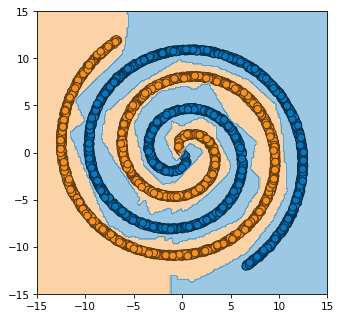

In [20]:
nn.test_plot(predictions)

In [10]:
%load_ext tensorboard

In [25]:
!kill 30935

In [27]:
%tensorboard --logdir logs/ --port 1112